# Analysis of Banking Marketing Campaigns for Term Deposits
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) was subscribed or not.

Data set has 20 predictor variables (features) and around 41K rows.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn

import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("/content/bank-additional-full.csv", sep =";")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


The last column in the dataset 'y' is our response. This report tries to get the best model to predict the subscription of term deposit. This report is divided into five sections. Graphical analysis is explored in Section 2, various methodologies to treat imbalance in data is discussed in Section 3, different models are fit in Section 4 and conclusive remarks are drawn in Section 5.

In [ ]:
# To check the datatypes of the parameters
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
#To check for null values
data.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


## Univariate Analysis

In [ ]:
#Breaking down the original dataset into two segments on the basis of the `y` predictor variable i.e Yes/No category
data1 = data[data['y'] == 'yes']
data2 = data[data['y'] == 'no']

In [ ]:
#To check for number of clients subscribed or not for their term deposits
print("Total Number of clients who have subscribed for their Term Deposits are",len(data1))
print("Total Number of clients who have NOT subscribed for their Term Deposits are", len(data2))

Total Number of clients who have subscribed for their Term Deposits are 4640
Total Number of clients who have NOT subscribed for their Term Deposits are 36548


<Axes: xlabel='y', ylabel='count'>

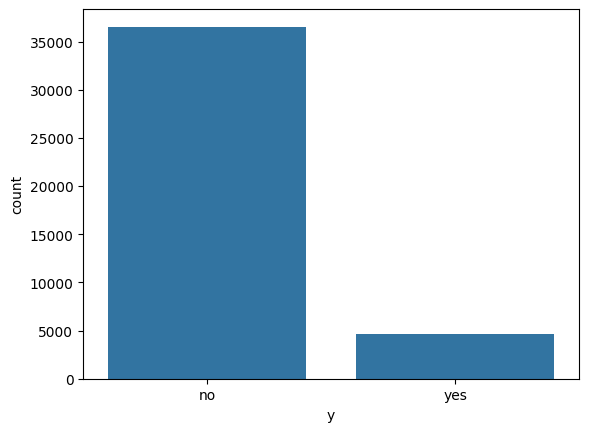

In [ ]:
# Plotting the 'subscribed' frequency
sns.countplot(data=data, x='y')

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64


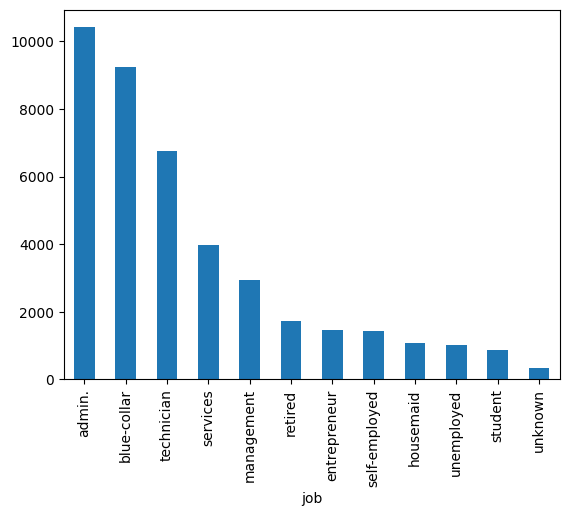

In [ ]:
# Analysing Job Variable and drawing the Frequency table
print(data['job'].value_counts())

data['job'].value_counts().plot(kind='bar');

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64


<Axes: xlabel='marital', ylabel='count'>

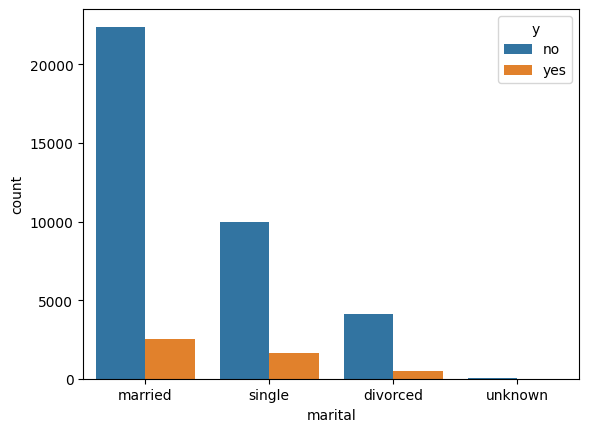

In [ ]:
# Analysing Marital Status
print(data['marital'].value_counts())

sns.countplot(data=data, x='marital', hue = "y")

## Bivariate Analysis

In [ ]:
# Crosstab between types of jobs and number of subscribers
print(pd.crosstab(data["job"], data['y']))

y                no   yes
job                      
admin.         9070  1352
blue-collar    8616   638
entrepreneur   1332   124
housemaid       954   106
management     2596   328
retired        1286   434
self-employed  1272   149
services       3646   323
student         600   275
technician     6013   730
unemployed      870   144
unknown         293    37


From this we can assume that people with `Admin` jobs have not subscribed to their Term Deposits.

In [ ]:
# Crosstab between marital status and number of subscribers
pd.crosstab(data['marital'], data['y'])

y,no,yes
marital,,
divorced,4136,476
married,22396,2532
single,9948,1620
unknown,68,12


In [ ]:
#Filtering data containing only numerical variables
filtered_data = data[["age","duration","campaign","pdays","previous","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]]
filtered_data

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6


<Axes: >

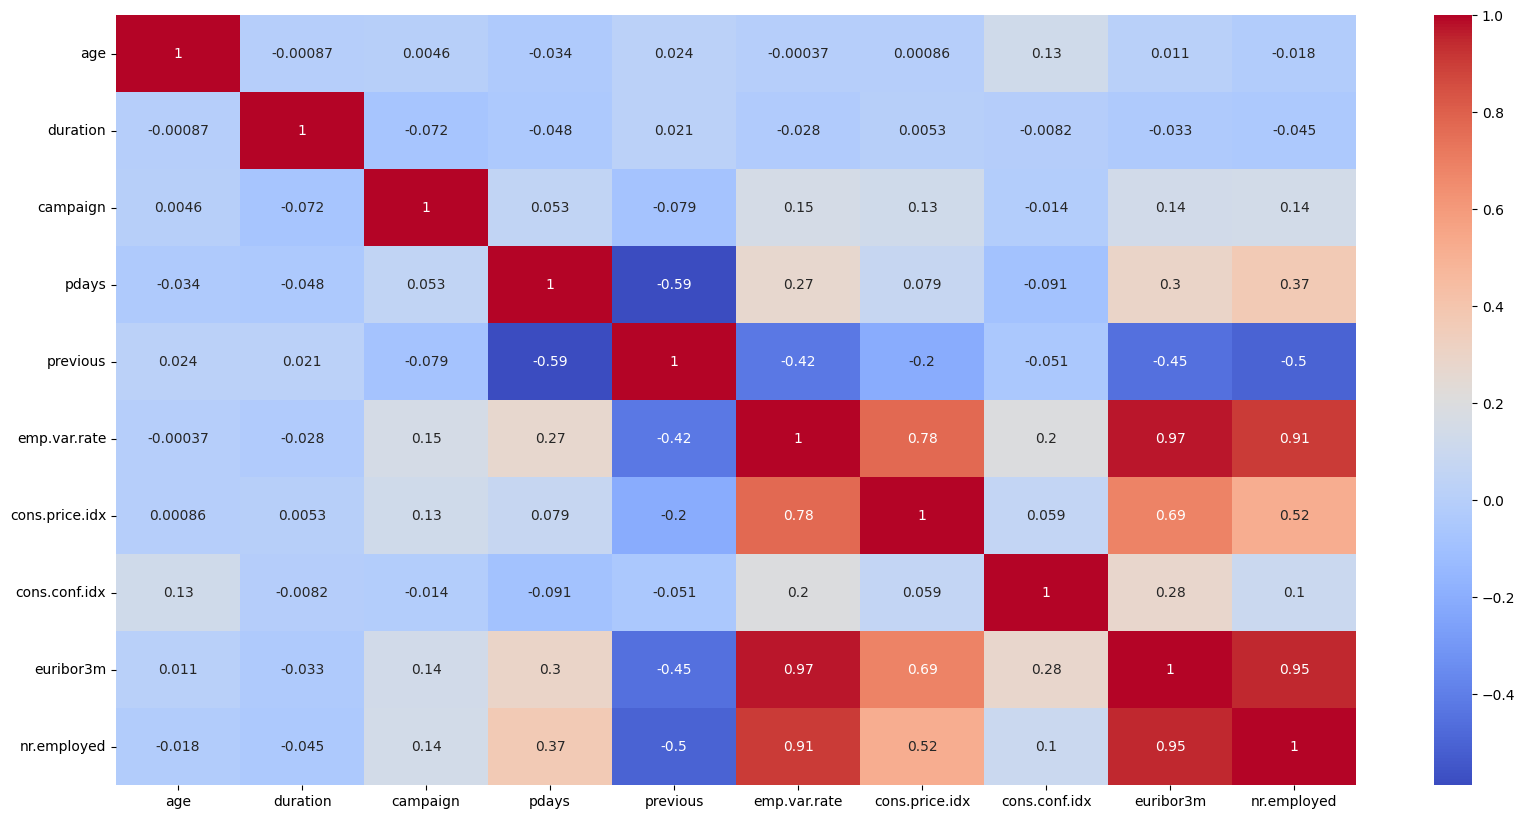

In [ ]:
# HeatMap
plt.figure(figsize=(20,10))
sns.heatmap(filtered_data.corr(), annot=True, cmap='coolwarm')

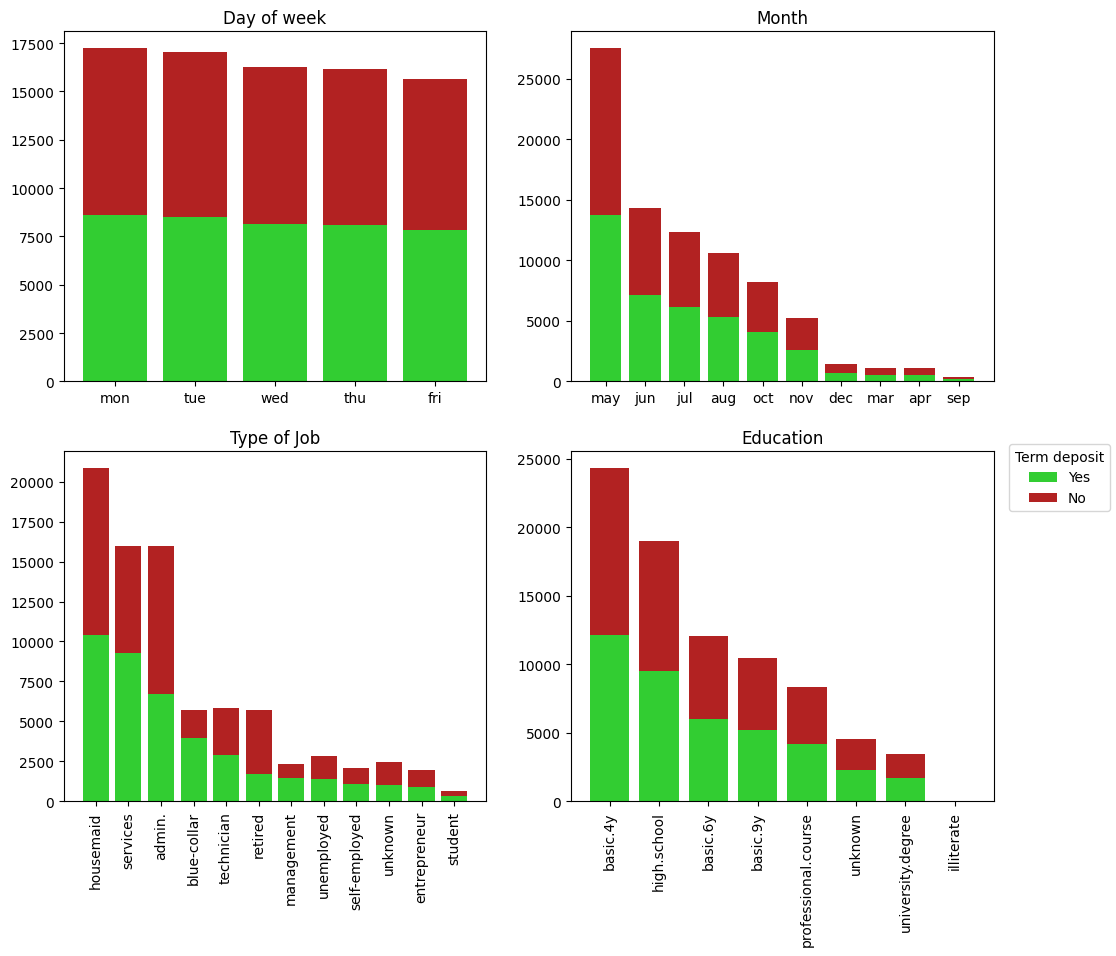

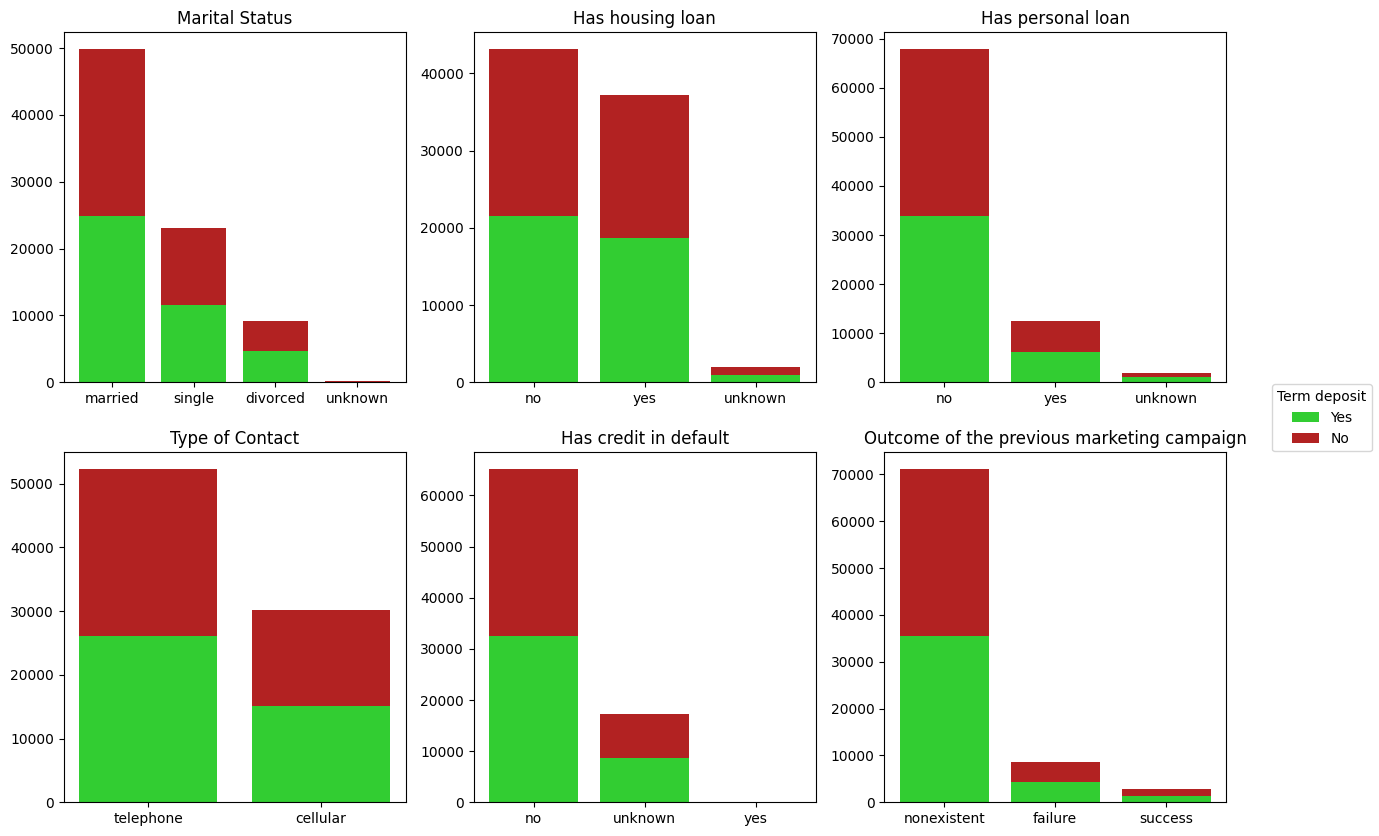

In [ ]:
#Visualizing categorical variables
fig, ax = plt.subplots(2, 2, figsize=(12,10))

b1 = ax[0, 0].bar(data['day_of_week'].unique(),height = data['day_of_week'].value_counts(),color='limegreen')
b2 = ax[0, 0].bar(data['day_of_week'].unique(),height = data['day_of_week'].value_counts(),bottom = data['day_of_week'].value_counts(),color = 'firebrick')
ax[0, 0].title.set_text('Day of week')

ax[0, 1].bar(data['month'].unique(),height = data['month'].value_counts(),color='limegreen')
ax[0, 1].bar(data['month'].unique(),height = data['month'].value_counts(),bottom = data['month'].value_counts(),color = 'firebrick')
ax[0, 1].title.set_text('Month')

ax[1, 0].bar(data['job'].unique(),height = data['job'].value_counts(),color='limegreen')
ax[1, 0].bar(data['job'].unique(),height = data['job'].value_counts()[data1['job'].value_counts().index],bottom = data['job'].value_counts(),color = 'firebrick')
ax[1, 0].title.set_text('Type of Job')
ax[1, 0].tick_params(axis='x',rotation=90)

ax[1, 1].bar(data['education'].unique(),height = data['education'].value_counts(),color='limegreen') #row=0, col=1
ax[1, 1].bar(data['education'].unique(),height = data['education'].value_counts()[data['education'].value_counts().index],bottom = data['education'].value_counts(),color = 'firebrick')
ax[1, 1].title.set_text('Education')
ax[1, 1].tick_params(axis='x',rotation=90)

plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")
plt.show()

fig, ax = plt.subplots(2, 3, figsize=(15,10))

b1 = ax[0, 0].bar(data['marital'].unique(),height = data['marital'].value_counts(),color='limegreen')
b2 = ax[0, 0].bar(data['marital'].unique(),height = data['marital'].value_counts()[data['marital'].value_counts().index],bottom = data['marital'].value_counts(),color = 'firebrick')
ax[0, 0].title.set_text('Marital Status')
#ax[0, 0].legend((b1[0], b2[0]), ('Yes', 'No'))

ax[0, 1].bar(data['housing'].unique(),height = data['housing'].value_counts(),color='limegreen')
ax[0, 1].bar(data['housing'].unique(),height = data['housing'].value_counts()[data1['housing'].value_counts().index],bottom = data['housing'].value_counts(),color = 'firebrick')
ax[0, 1].title.set_text('Has housing loan')

ax[0, 2].bar(data['loan'].unique(),height = data['loan'].value_counts(),color='limegreen')
ax[0, 2].bar(data['loan'].unique(),height = data['loan'].value_counts()[data1['loan'].value_counts().index],bottom = data['loan'].value_counts(),color = 'firebrick')
ax[0, 2].title.set_text('Has personal loan')

ax[1, 0].bar(data['contact'].unique(),height = data['contact'].value_counts(),color='limegreen')
ax[1, 0].bar(data['contact'].unique(),height = data['contact'].value_counts()[data1['contact'].value_counts().index],bottom = data['contact'].value_counts(),color = 'firebrick')
ax[1, 0].title.set_text('Type of Contact')

ax[1, 1].bar(data['default'].unique(),height = data['default'].value_counts(),color='limegreen')
ax[1, 1].bar(data['default'].unique(),height = data['default'].value_counts()[data['default'].value_counts().index],bottom = data['default'].value_counts(),color = 'firebrick')
ax[1, 1].title.set_text('Has credit in default')

ax[1, 2].bar(data['poutcome'].unique(),height = data['poutcome'].value_counts(),color='limegreen')
ax[1, 2].bar(data['poutcome'].unique(),height = data['poutcome'].value_counts()[data['poutcome'].value_counts().index],bottom = data['poutcome'].value_counts(),color = 'firebrick')
ax[1, 2].title.set_text('Outcome of the previous marketing campaign')

plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")
plt.show()

All categories across the categorical variables show a disproportionate number of 'yes' responses compared to 'no' for term deposit subscriptions. A noteworthy observation is in the 'Outcome of the previous marketing campaign' variable, where the 'failure' category has a higher number of 'yes' responses than 'no'. This indicates that customers who initially declined to subscribe during a previous campaign were more likely to subscribe after follow-up calls. For the 10 continuous variables, unstacked histograms are plotted below.

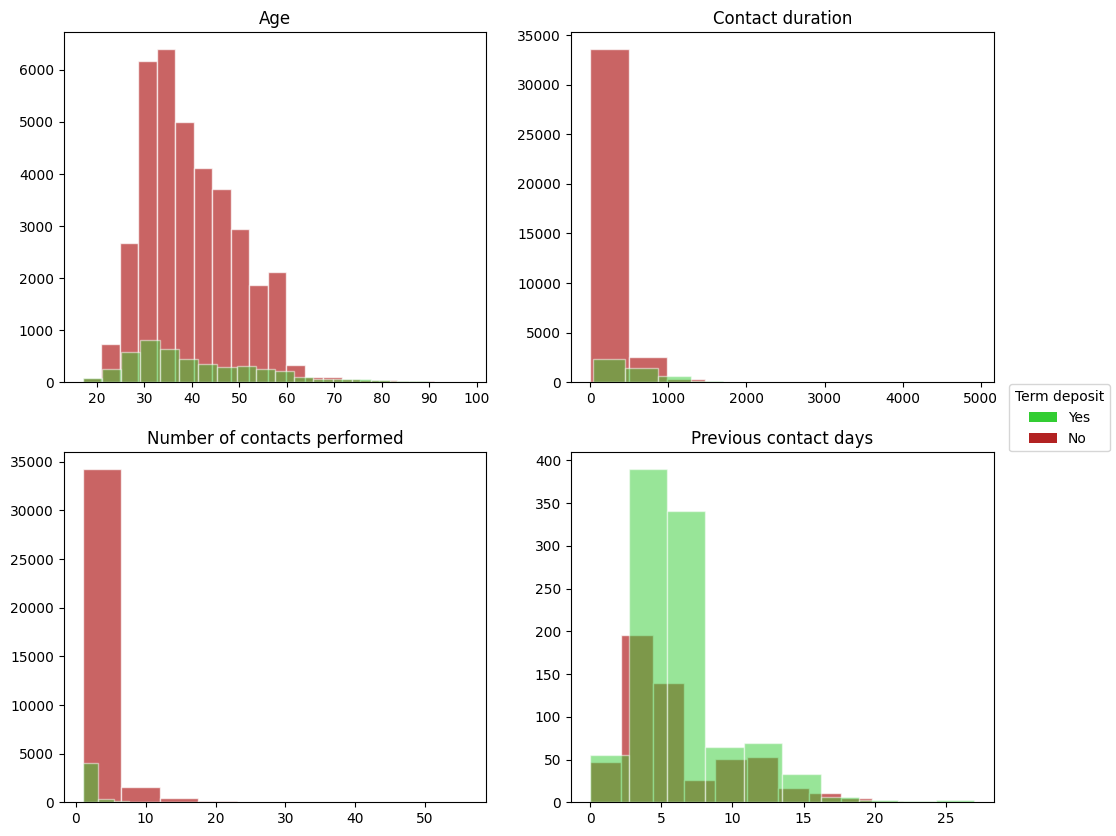

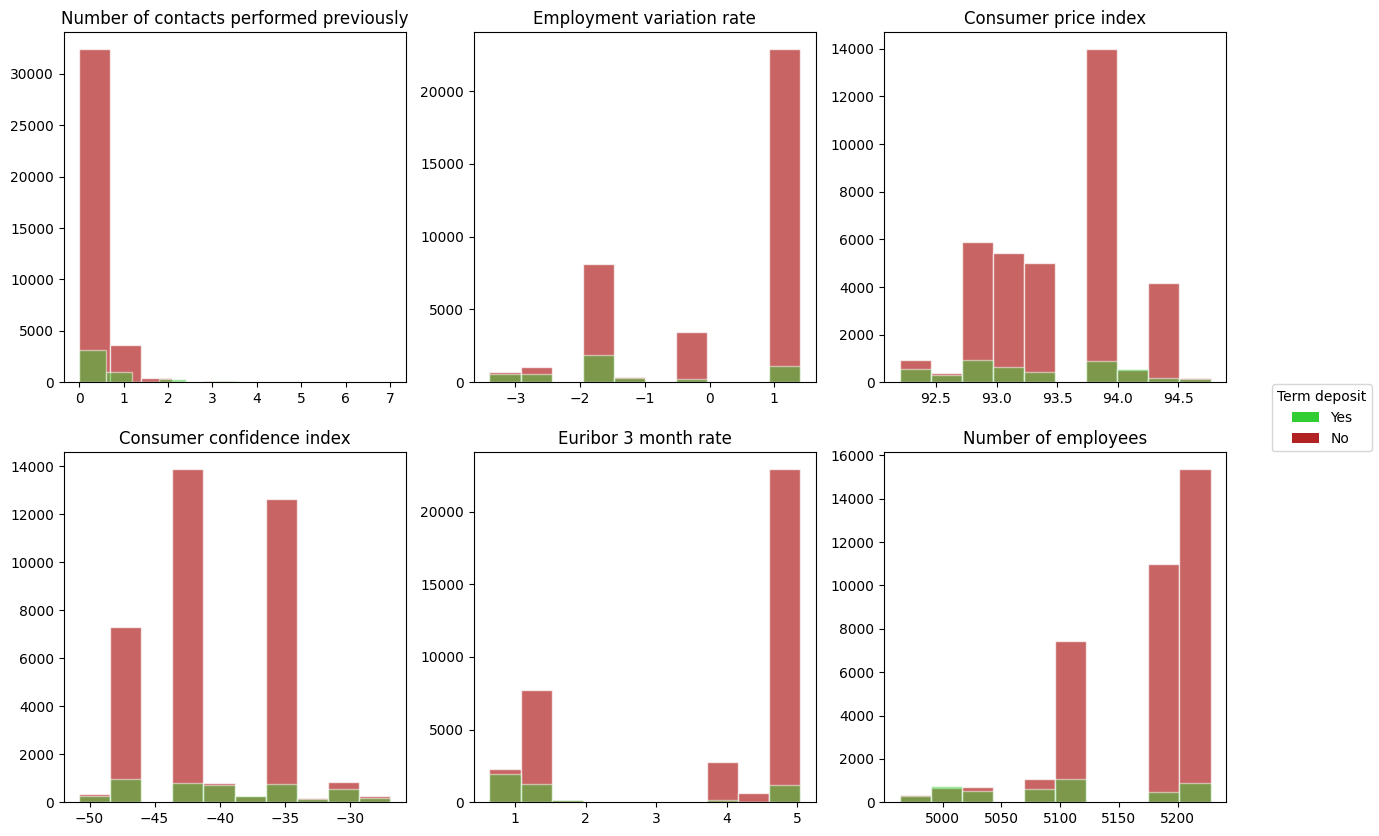

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))

ax[0, 0].hist(data2['age'],color = 'firebrick',alpha=0.7,bins=20, edgecolor='white')
ax[0, 0].hist(data1['age'],color='limegreen',alpha=0.5,bins=20, edgecolor='white')
ax[0, 0].title.set_text('Age')

ax[0, 1].hist(data2['duration'],color = 'firebrick',alpha=0.7, edgecolor='white')
ax[0, 1].hist(data1['duration'],color='limegreen',alpha=0.5, edgecolor='white')
ax[0, 1].title.set_text('Contact duration')

ax[1, 0].hist(data2['campaign'],color = 'firebrick',alpha=0.7, edgecolor='white')
ax[1, 0].hist(data1['campaign'],color='limegreen',alpha=0.5, edgecolor='white')
ax[1, 0].title.set_text('Number of contacts performed')

ax[1, 1].hist(data2[data2['pdays'] != 999]['pdays'],color = 'firebrick',alpha=0.7, edgecolor='white')
ax[1, 1].hist(data1[data1['pdays'] != 999]['pdays'],color='limegreen',alpha=0.5, edgecolor='white')
ax[1, 1].title.set_text('Previous contact days')

plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")
plt.show()

fig, ax = plt.subplots(2, 3, figsize=(15,10))

ax[0, 0].hist(data2['previous'],color = 'firebrick',alpha=0.7, edgecolor='white')
ax[0, 0].hist(data1['previous'],color='limegreen',alpha=0.5, edgecolor='white')
ax[0, 0].title.set_text('Number of contacts performed previously')

ax[0, 1].hist(data2['emp.var.rate'],color = 'firebrick',alpha=0.7, edgecolor='white')
ax[0, 1].hist(data1['emp.var.rate'],color='limegreen',alpha=0.5, edgecolor='white')
ax[0, 1].title.set_text('Employment variation rate')

ax[0, 2].hist(data2['cons.price.idx'],color = 'firebrick',alpha=0.7, edgecolor='white')
ax[0, 2].hist(data1['cons.price.idx'],color='limegreen',alpha=0.5, edgecolor='white')
ax[0, 2].title.set_text('Consumer price index')

ax[1, 0].hist(data2['cons.conf.idx'],color = 'firebrick',alpha=0.7, edgecolor='white')
ax[1, 0].hist(data1['cons.conf.idx'],color='limegreen',alpha=0.5, edgecolor='white')
ax[1, 0].title.set_text('Consumer confidence index')

ax[1, 1].hist(data2['euribor3m'],color = 'firebrick',alpha=0.7, edgecolor='white')
ax[1, 1].hist(data1['euribor3m'],color='limegreen',alpha=0.5, edgecolor='white')
ax[1, 1].title.set_text('Euribor 3 month rate')

ax[1, 2].hist(data2['nr.employed'],color = 'firebrick',alpha=0.7, edgecolor='white')
ax[1, 2].hist(data1['nr.employed'],color='limegreen',alpha=0.5, edgecolor='white')
ax[1, 2].title.set_text('Number of employees')

plt.figlegend((b1[0], b2[0]), ('Yes', 'No'),loc="right",title = "Term deposit")
plt.show()

All the histograms show similar behavior (proportion of 'no' is higher than 'yes') except 'Previous contact days'. Proportion of 'yes' is higher compared to 'no' (only if contacted more than once).

## Model Fitting and Treating Imbalanced Data

Now, we will create our model and run the following Machine Learning algorithms -
1. Logistic Regression Model
2. Decison Tree
3. Random Forest


In [ ]:
predictors = data.iloc[:,0:20]
predictors = predictors.drop(['pdays'],axis=1)
y = data.iloc[:,20]
X = pd.get_dummies(predictors)


Given data set is highly imbalanced, i.e. number of data belonging to 'no' category is way higher than 'yes' category.

> Add blockquote



In [ ]:
y.value_counts()

,count
y,
no,36548
yes,4640


This imbalance is to be treated so that there is no bias in modeling. Imbalance is generally treated in three ways.
- RANDOM UNDRSAMPLING
- RANDOM OVERSAMPLING
- SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE (SMOTE)

### A) Random Undersampling

In this method, the majority category, in this case 'no' category is randomly sampled to match the size of the minority 'yes' category. Remaining data of majority category is discarded.

In [ ]:
rus = RandomUnderSampler(random_state=0)

X_Usampled, y_Usampled = rus.fit_resample(X, y)

pd.Series(y_Usampled).value_counts()

,count
y,
no,4640
yes,4640


### B) Random Oversampling

In this method, the minority category 'no' is randomly sampled with replacement to match the size of the majority 'no' category. Minority category entries will be repeated many times.

In [ ]:
ros = RandomOverSampler(random_state=0)

X_Osampled, y_Osampled = ros.fit_resample(X, y)

pd.Series(y_Osampled).value_counts()

,count
y,
no,36548
yes,36548


### C) SMOTE - Synthetic Minority Oversampling Technique

This is an oversampling technique in which instead of randomly repeating minority 'yes' category, new entires are sythetically created maintaining the convexity of minority entry space. Minority category will again match the majority category samples.

In [ ]:
sm = SMOTE(random_state=0)

X_SMOTE, y_SMOTE = sm.fit_resample(X, y)

pd.Series(y_SMOTE).value_counts()

,count
y,
no,36548
yes,36548


These different imbalance treatements will be used in different data modeling techniques based on the need.

In [ ]:
# building X_Test, Y_Test, X_Train, Y_Train

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)

Now our data is ready and it's time to build our model and check its performance. Since it's a classification problem, we'll be using Logistic Regression model for this problem

### 1. Logistic Regression Model

In [ ]:
# Imbalanced Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
model = lm.LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto',max_iter=1000)
model.fit(X_train,y_train)

y_pred = model.predict_proba(X_test)
y_pred = y_pred[:,1]

y_test = label_binarize(y_test,classes=['no','yes'])
fpr_imb, tpr_imb, _ = roc_curve(y_test, y_pred)
roc_auc_imb = auc(fpr_imb, tpr_imb)

y_pred = model.predict(X_test)
y_pred = label_binarize(y_pred,classes=['no','yes'])

print("Imbalanced Data -")
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
print("Accuracy: ",round(accuracy_score(y_test, y_pred)*100,2),"%")

Imbalanced Data -
Precision:  0.68 Recall:  0.41
Accuracy:  90.89 %


In [ ]:
# Undersampled Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
rus = RandomUnderSampler(random_state=0)
X_Usampled, y_Usampled = rus.fit_resample(X_train, y_train)

model = lm.LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto',max_iter=5000).fit(X_Usampled,y_Usampled)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:,1]

y_test = label_binarize(y_test,classes=['no','yes'])
fpr_us, tpr_us, _ = roc_curve(y_test, y_pred)
roc_auc_us = auc(fpr_us, tpr_us)

y_pred = model.predict(X_test)
y_pred = label_binarize(y_pred,classes=['no','yes'])

print("Random undersampled Data -")
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
print("Accuracy: ",round(accuracy_score(y_test, y_pred)*100,2),"%")

Random undersampled Data -
Precision:  0.46 Recall:  0.87
Accuracy:  86.49 %


In [ ]:
# Oversampled Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ros = RandomOverSampler(random_state=0)
X_Osampled, y_Osampled = ros.fit_resample(X_train, y_train)

model = lm.LogisticRegression(random_state=0, solver='lbfgs',multi_class='auto',max_iter=5000).fit(X_Osampled, y_Osampled)
y_pred = model.predict_proba(X_test)
y_pred = y_pred[:,1]

y_test = label_binarize(y_test,classes=['no','yes'])
fpr_os, tpr_os, _ = roc_curve(y_test, y_pred)
roc_auc_os = auc(fpr_os, tpr_os)

y_pred = model.predict(X_test)
y_pred = label_binarize(y_pred,classes=['no','yes'])

print("Random oversampled Data -")
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
print("Accuracy: ",round(accuracy_score(y_test, y_pred)*100,2),"%")

Random oversampled Data -
Precision:  0.44 Recall:  0.89
Accuracy:  86.44 %


We got an accuracy score of around `86%` on the validation dataset for both `Undersampled` and `Oversampled` data. Logistic regression has a linear decision boundary.

Using Decision Tree algorithm we are going to deal with non-linearity

ROC curve depicts the variation of `True Positive Rate` to False Positive Rate.
`Area under ROC curve` is slightly better for over sampled data compared to imbalanced and undersampled data.

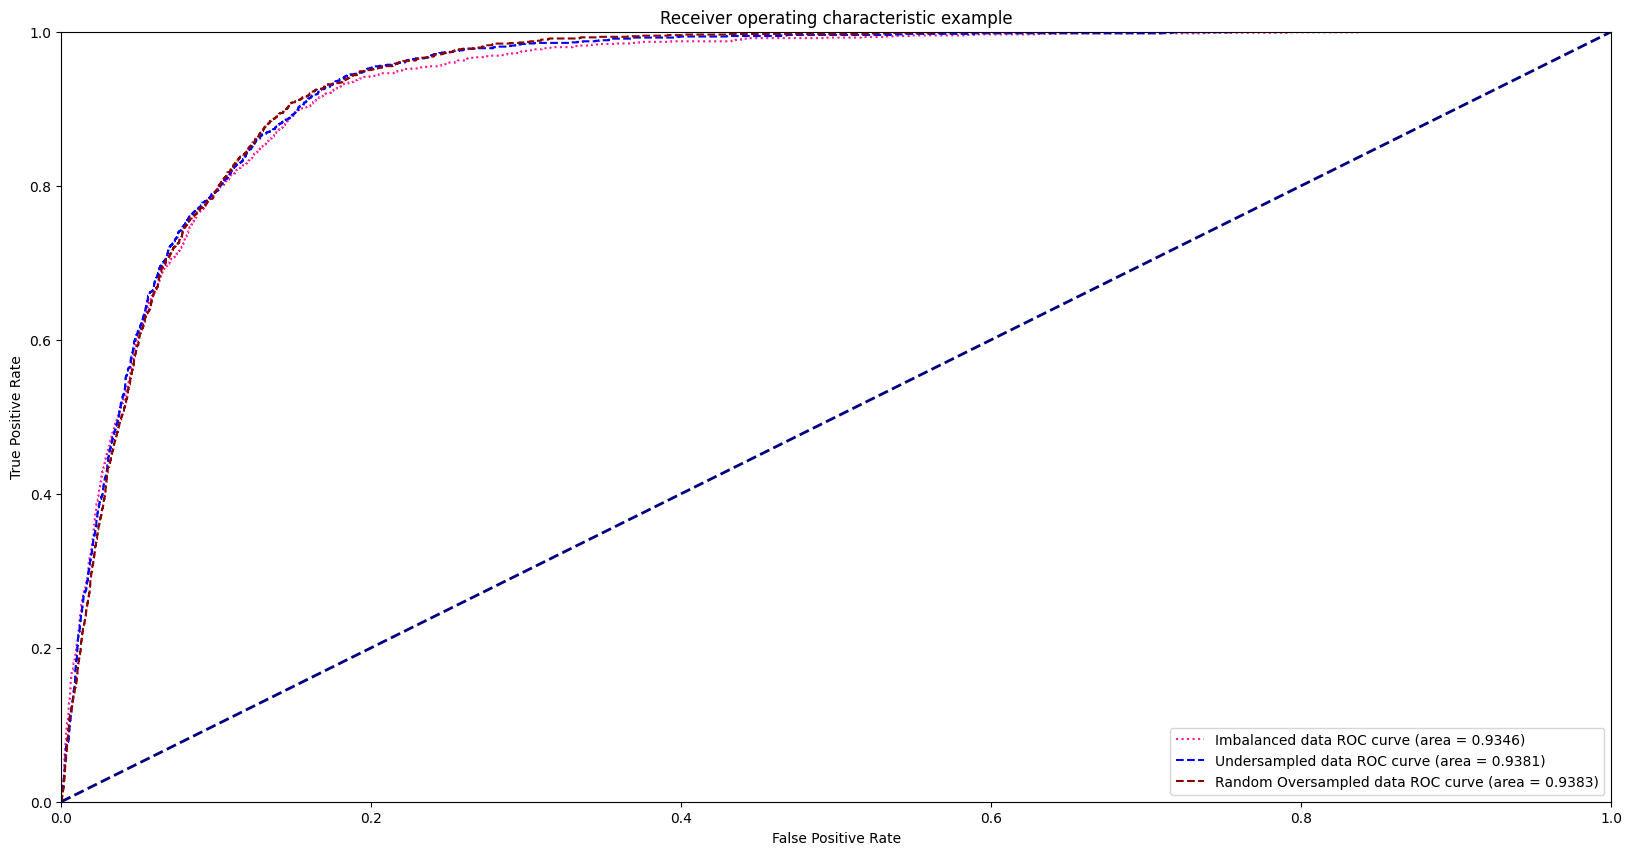

In [ ]:
# Calculating ROC Curves
plt.figure(figsize=(20,10))
lw = 2
plt.plot(fpr_imb, tpr_imb,
         label='Imbalanced data ROC curve (area = {0:0.4f})'
               ''.format(roc_auc_imb),
         color='deeppink', linestyle=':')

plt.plot(fpr_us, tpr_us,
         label='Undersampled data ROC curve (area = {0:0.4f})'
               ''.format(roc_auc_us),
         color='blue', linestyle='--')

plt.plot(fpr_os, tpr_os,
         label='Random Oversampled data ROC curve (area = {0:0.4f})'
               ''.format(roc_auc_os),
         color='darkred', linestyle='--')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.show()

### 2. Decision Tree Model
Decision tree is another simple yet powerful classification tool. But this model faces the same problem of bad precision score and bad recall score for imbalanced data.

In [ ]:
# Creating train and Test Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
tree = DecisionTreeClassifier(criterion="entropy", max_depth=7, random_state=0)

model = tree.fit(X_train,y_train)
y_pred = model.predict(X_test)

y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])

In [ ]:
# Calculating the accuracy
print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
print("Accuracy For Decision Tree Model is:",round(accuracy_score(y_test, y_pred)*100,2), "%")

Precision:  0.64 Recall:  0.54
Accuracy For Decision Tree Model is: 91.58 %


When decision tree is fit on SMOTE data, recall score improves but precision score deteriorates.

In [ ]:
# Training Model on SMOTE Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
tree = DecisionTreeClassifier(criterion="entropy", max_depth=7)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)

# SMOTE Data
model = tree.fit(X_SMOTE,y_SMOTE)
y_pred = model.predict(X_test)

y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])

print("Precision: ", round(precision_score(y_test,y_pred),2),"Recall: ", round(recall_score(y_test,y_pred),2))
print("Accuracy for Decision Tree Model is ",round(accuracy_score(y_pred,y_test)*100,2),"%")

Precision:  0.47 Recall:  0.82
Accuracy for Decision Tree Model is  87.76 %


### 3. Random Forest Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

forest = RandomForestClassifier(n_estimators= 1000,criterion="gini", max_depth=5,min_samples_split = 0.4,min_samples_leaf=1, class_weight="balanced")
model = forest.fit(X_train,y_train)

y_pred = model.predict(X_test)
pd.Series(y_pred).value_counts()

y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])

print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
print("Accuracy for Random Forest Model is ",round(accuracy_score(y_pred,y_test)*100,2),"%")

Precision:  0.29 Recall:  0.74
Accuracy for Random Forest Model is  75.73 %



Random forest classification hardly performs better when applied on SMOTE data in terms of precision and recall.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

forest = RandomForestClassifier(n_estimators= 1000,criterion="gini", max_depth=5,min_samples_split = 0.4,min_samples_leaf=1, class_weight="balanced")
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)

model = forest.fit(X_SMOTE,y_SMOTE)
y_pred = model.predict(X_test)
pd.Series(y_pred).value_counts()

y_test = label_binarize(y_test,classes=['no','yes'])
y_pred = label_binarize(y_pred,classes=['no','yes'])

print("Precision: ",round(precision_score(y_test,y_pred),2),"Recall: ",round(recall_score(y_test,y_pred),2))
print("Accuracy for Random Forest Model is ",round(accuracy_score(y_pred,y_test)*100,2),"%")

Precision:  0.35 Recall:  0.68
Accuracy for Random Forest Model is  82.03 %


## Conclusion

For the given data, visualization of data, ways to treat imbalance in the data and best predictive model to determine the term deposit subscription was explored. From visualization, it can be derived that repeated campaign calls to customers within 20 days of previous call increases the subscription.
After treating the imbalance in data, Decision Tree Model performed the best in terms of accuracy score of `87.76%`.